# SWB analysis pipeline part 4: 

Freq-Band Averaged Time Courses - Single ROI

*Created: 07/14/24* \
*Updated: 09/30/2024*


In [ ]:
# def moving_average(a, n=11) :
#     """
#     Computes the moving average of a given array a with a window size of n.

#     Parameters
#     ----------
#     a : np.ndarray
#         The input array to compute the moving average on.
#     n : int, optional
#         The window size of the moving average. Default is 11.

#     Returns
#     -------
#     np.ndarray
#         The moving average of the input array a.
#     """
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n

In [5]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [6]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

09302024


In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

sys.path.append(f'{script_dir}behav/')

from behav_utils import *
from swb_subj_behav import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [9]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [10]:
### load ROI reref master 
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])
roi_reref_labels_master_df



,subj_id,reref_ch_names,ch_label4roi,ch_type4roi,loc4roi,mni_x,mni_y,mni_z,hemi,roi
0,MS002,lacas1-lacas2,lacas1,anode,left cingulate gyrus d,-6.382462,37.158688,-3.130044,l,acc
1,MS002,lacas2-lacas3,lacas2,anode,left cingulate gyrus e,-6.368174,38.606223,2.270621,l,acc
2,MS002,lacas3-lacas4,lacas3,anode,left cingulate gyrus f,-6.390079,39.941566,7.640265,l,acc
3,MS002,lacas4-lacas5,lacas4,anode,left cingulate gyrus f,-6.914519,41.546899,12.993427,l,acc
4,MS002,lacas5-lacas6,lacas5,anode,left cingulate gyrus g,-6.933604,42.745784,18.267675,l,acc
...,...,...,...,...,...,...,...,...,...,...
1875,DA039,rtp6-rtp7,rtp6,anode,right superior middle temporal pole d,40.532268,7.354525,-33.253436,r,temporal pole
1876,DA039,rtp7-rtp8,rtp7,anode,right superior middle temporal pole d,43.911226,7.341369,-31.915085,r,temporal pole
1877,DA039,rsgcc6-rsgcc7,rsgcc7,cathode,right anterior pars triangularis b,42.378987,31.277597,2.471854,r,vlpfc
1878,DA039,rsgcc7-rsgcc8,rsgcc7,anode,right anterior pars triangularis b,42.378987,31.277597,2.471854,r,vlpfc


In [11]:
roi_reref_labels_master_df['roi'].value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

# LOAD ROI/FREQ DATA

In [12]:
freqs = {'hfa':np.array([70,200]),'gamma':np.array([30,70]),'beta':np.array([13,30]),
         'alpha':np.array([8,13]),'theta':np.array([4,8])}

In [13]:
### plot_roi = roi str according to roi_reref_labels_master
plot_roi   = 'ofc'
### plot_band = str id of band to plot
plot_band  = 'hfa'
### freq_range = np array of upper/lower freq bounds of plot_band - either manual or subset from freqs above
# freq_range = np.array([9,12])
freq_range = freqs[plot_band]

In [14]:
# all_behav = pd.read_csv(f'{behav_dir}all_behav.csv') ## this isn't normalized yet 
raw_behav = [pd.read_csv(f'{base_dir}ephys_analysis/behav/data/{subj_id}_task_df.csv') for subj_id in subj_ids]
all_behav,drops_data = format_all_behav(raw_behav,drops_data=True)

all_behav

,subj_id,bdi,bdi_thresh,Round,RT,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,ChoicePos,...,choiceEV_t1,rpe_t1,res_type_t1,cf_t1,max_cf_t1,cpe_t1,max_cpe_t1,keep_epoch,keep_epoch_t1,CpeOnset
0,MS002,14,low,1,2.059852,513.380590,513.390239,515.450091,515.457173,right,...,-0.748193,-0.553325,gamble_bad,-0.151490,0.017828,-0.451721,-0.457514,keep,keep,517.450091
1,MS002,14,low,2,1.954564,522.640856,522.641563,524.596127,526.627092,right,...,1.074702,0.954543,gamble_good,0.278569,0.017828,0.731568,0.723865,keep,keep,526.596127
2,MS002,14,low,3,1.583462,531.174799,531.175599,532.759061,534.780269,right,...,-0.089733,-0.008658,safe_good,-0.458674,-0.387722,0.437278,0.328575,keep,keep,534.759061
3,MS002,14,low,4,2.491611,545.592613,545.593355,548.084966,548.092333,left,...,0.769731,0.702276,gamble_good,0.340006,0.017828,0.400492,0.526220,keep,keep,550.084966
4,MS002,14,low,5,1.768936,555.337336,555.345720,557.114656,559.135069,left,...,-0.089733,-0.008658,safe_good,-0.642985,-0.539803,0.621209,0.463333,keep,keep,559.114656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,DA039,22,high,146,1.079701,2259.827656,2259.828749,2260.908450,2262.926195,right,...,-0.128169,0.007477,safe_good,-1.322517,-0.943820,0.970134,0.636137,keep,keep,2262.908450
4046,DA039,22,high,147,1.837272,2267.502359,2267.534059,2269.371331,2269.377701,right,...,-0.128169,0.007477,safe_bad,0.374778,0.215896,-0.312218,-0.167905,keep,keep,2271.371331
4047,DA039,22,high,148,4.030006,2282.349445,2282.350662,2286.380667,2286.389886,left,...,-0.128169,0.007477,safe_bad,0.383664,0.221967,-0.318932,-0.172115,keep,keep,2288.380667
4048,DA039,22,high,149,3.167144,2293.040983,2293.042042,2296.209186,2296.218136,left,...,-1.591335,-1.093440,gamble_bad,-0.433881,-0.033049,-1.379726,-1.047721,keep,keep,2298.209186


In [15]:
#### add bdi and cpe split to behav df
regret_types = ['gamble_bad','safe_bad']

all_behav['cpe_split'] = all_behav['res_type'].apply(lambda x: 0 if (x == regret_types[0])|(
                                                        x == regret_types[1]) else 1)
# all_behav['bdi_split'] = all_behav['bdi'].apply(lambda x: 0 if x < 20 else 1)


In [16]:
roi_df = roi_reref_labels_master_df[roi_reref_labels_master_df.roi == plot_roi]
roi_df['unique_reref_ch'] = roi_df[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
roi_subjs  = roi_df.subj_id.unique().tolist()
roi_elecs  = {f'{subj}':roi_df[roi_df.subj_id == subj].unique_reref_ch.tolist() for subj in roi_subjs}
roi_elecs  = {f'{subj}':roi_df[roi_df.subj_id == subj].reref_ch_names.tolist() for subj in roi_subjs}

roi_elecs

{'MS002': ['lloif1-lloif2',
  'lloif2-lloif3',
  'lloif3-lloif4',
  'lmoif2-lmoif3',
  'rmoif1-rmoif2',
  'rmoif2-rmoif3',
  'rmoif3-rmoif4',
  'rmoif5-rmoif6',
  'rmoif6-rmoif7',
  'rmoif7-rmoif8'],
 'MS003': ['lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmolf4-lmolf5',
  'lmolf5-lmolf6',
  'lmolf6-lmolf7',
  'rmolf2-rmolf3',
  'rmolf3-rmolf4'],
 'MS009': ['lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmolf4-lmolf5',
  'lmolf5-lmolf6'],
 'MS011': ['lmolf1-lmolf2',
  'rmolf2-rmolf3',
  'rmolf3-rmolf4',
  'rmolf4-rmolf5',
  'rmolf5-rmolf6'],
 'MS015': ['lmolf2-lmolf3', 'lmolf3-lmolf4'],
 'MS016': ['lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmolf4-lmolf5',
  'lmolf5-lmolf6',
  'lmolf6-lmolf7'],
 'MS017': ['lmolf1-lmolf2', 'lmolf2-lmolf3', 'lmolf3-lmolf4', 'lmolf4-lmolf5'],
 'MS019': ['lmoif2-lmoif3',
  'lmoif3-lmoif4',
  'lmoif4-lmoif5',
  'lmoif5-lmoif6',
  'lmoif6-lmoif7'],
 'MS024': ['lmolf1-lmolf2',
  'lmolf2-lmolf3',
  'lmolf3-lmolf4',
  'lmol

In [17]:
del roi_df

In [18]:
roi_band_pow = []

for subj_id in roi_subjs:
    
    # load cpe power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5').crop(0,2.0)
    roi_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5').pick(roi_elecs[subj_id])
#     roi_epochs   = power_epochs.copy().pick_channels(roi_elecs[subj_id])
#     roi_epochs   = power_epochs.copy().pick(roi_elecs[subj_id])

#     del power_epochs
    
    roi_pow_df  = roi_epochs.to_data_frame()
    
    del roi_epochs
    
    roi_band_df = roi_pow_df[(roi_pow_df.freq >= freq_range[0])&(roi_pow_df.freq <= freq_range[1])].groupby(
                  ['epoch','time']).agg('mean',numeric_only=True).reset_index()
    
    del roi_pow_df
    
    roi_band_df  = roi_band_df.melt(id_vars=['epoch','time','freq'],
                                    value_vars=roi_elecs[subj_id],
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)
    
    
    subj_behav = all_behav[all_behav.subj_id == subj_id]

    subj_df = pd.merge(roi_band_df, subj_behav,on='epoch')
    
    del roi_band_df, subj_behav
    
    # add roi info to df 
    subj_roi_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id][
                                ['subj_id','reref_ch_names','roi','hemi']]
    
    subj_df = pd.merge(subj_df, subj_roi_labels,left_on=['reref_ch_names','subj_id'],
                                        right_on=['reref_ch_names','subj_id'])#.reset_index(drop=True)
    
    subj_df['unique_reref_ch'] = subj_df[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
    
    # drop bad epochs
    subj_drops = drops_data[subj_id]
    subj_df = subj_df[~subj_df['epoch'].isin(subj_drops)]

    
#     roi_band_pow[subj_id] = subj_df
    roi_band_pow.append(subj_df)
    del subj_df 
    
     

    

Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/MS002_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS003/MS003_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/MS009_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/MS011_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/MS015_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/MS016_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS017/MS017_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/MS019_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS024/MS024_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/MS025_CpeOnset-tfr.h5 ...
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/dat

In [19]:
roi_band_pow = pd.concat(roi_band_pow).reset_index(drop=True)

In [ ]:
# roi_plot_df.to_csv(f'{base_dir}ephys_analysis/results/timeseries_plot_data/{plot_roi}_{plot_band}_roi_plot_df.csv')


## Plot Data

In [20]:
sns.set_context('talk')
sns.set_style('ticks')

fig_dir   = f'{base_dir}ephys_analysis/figs/band_timeseries/{plot_band}/'
os.makedirs(fig_dir,exist_ok=True)

sem_colors = ['indianred','steelblue']
labels     = ['Negative CPE', 'Positive CPE']

sns.set_context('talk')


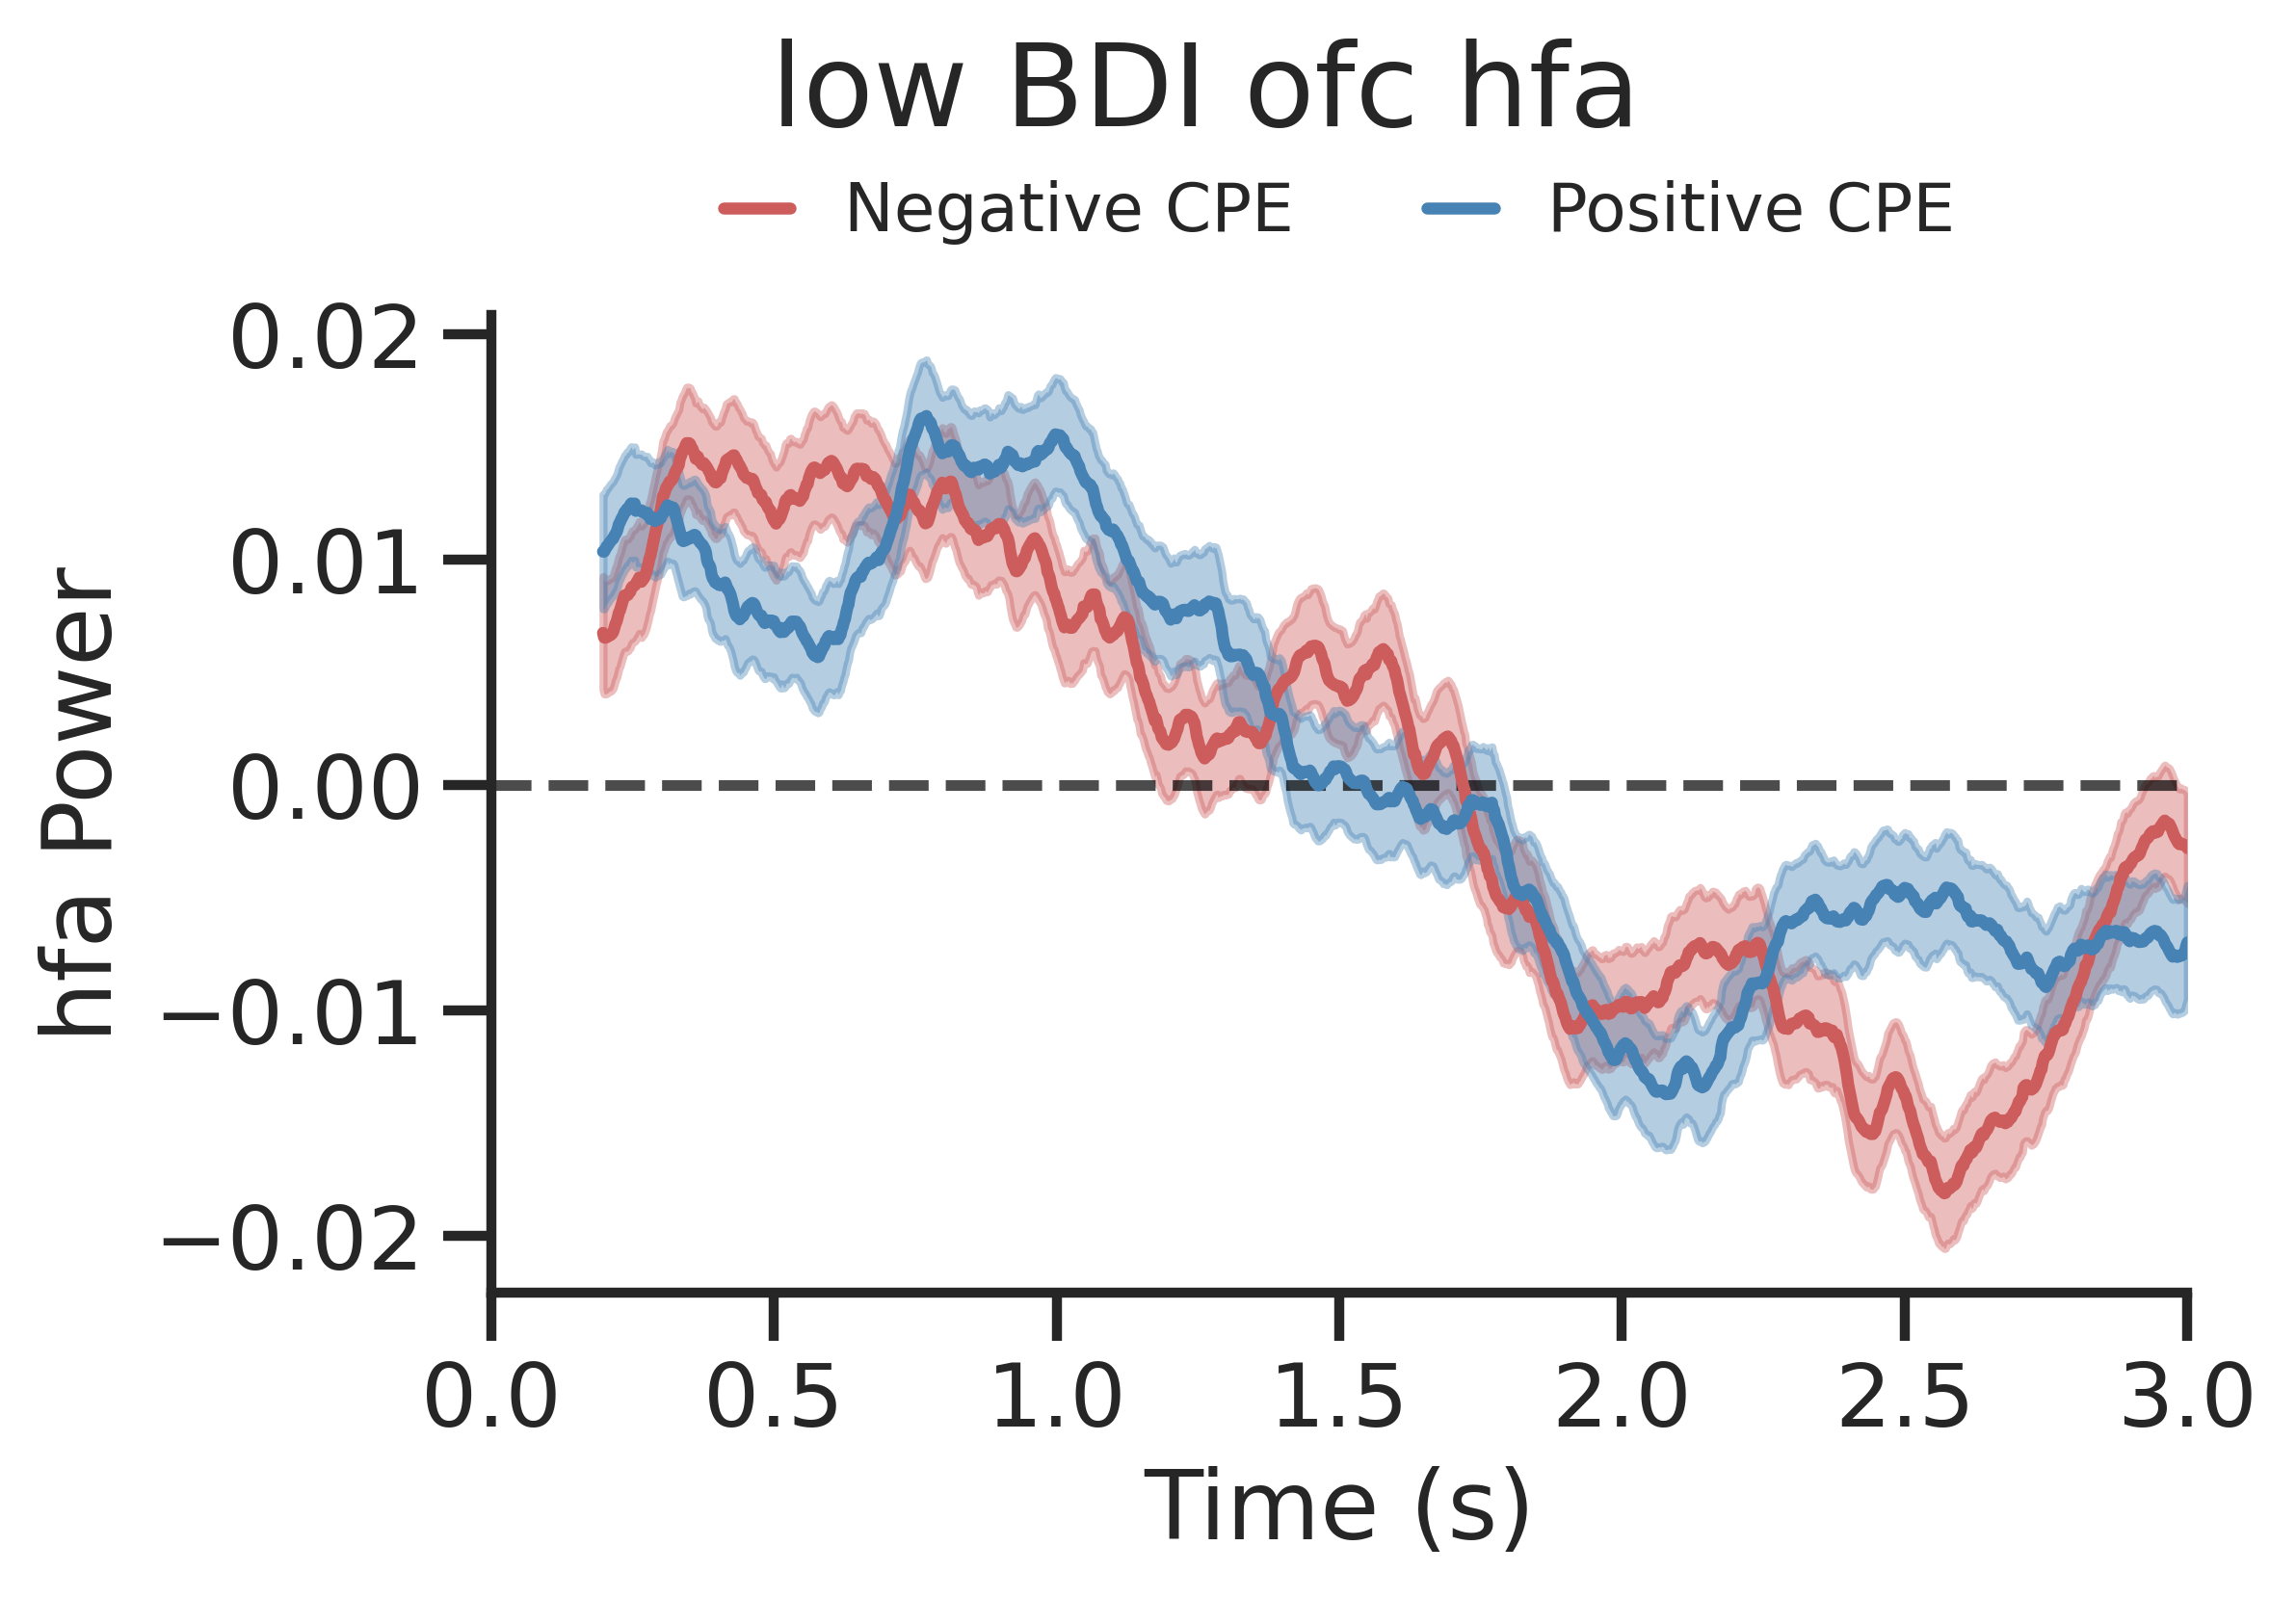

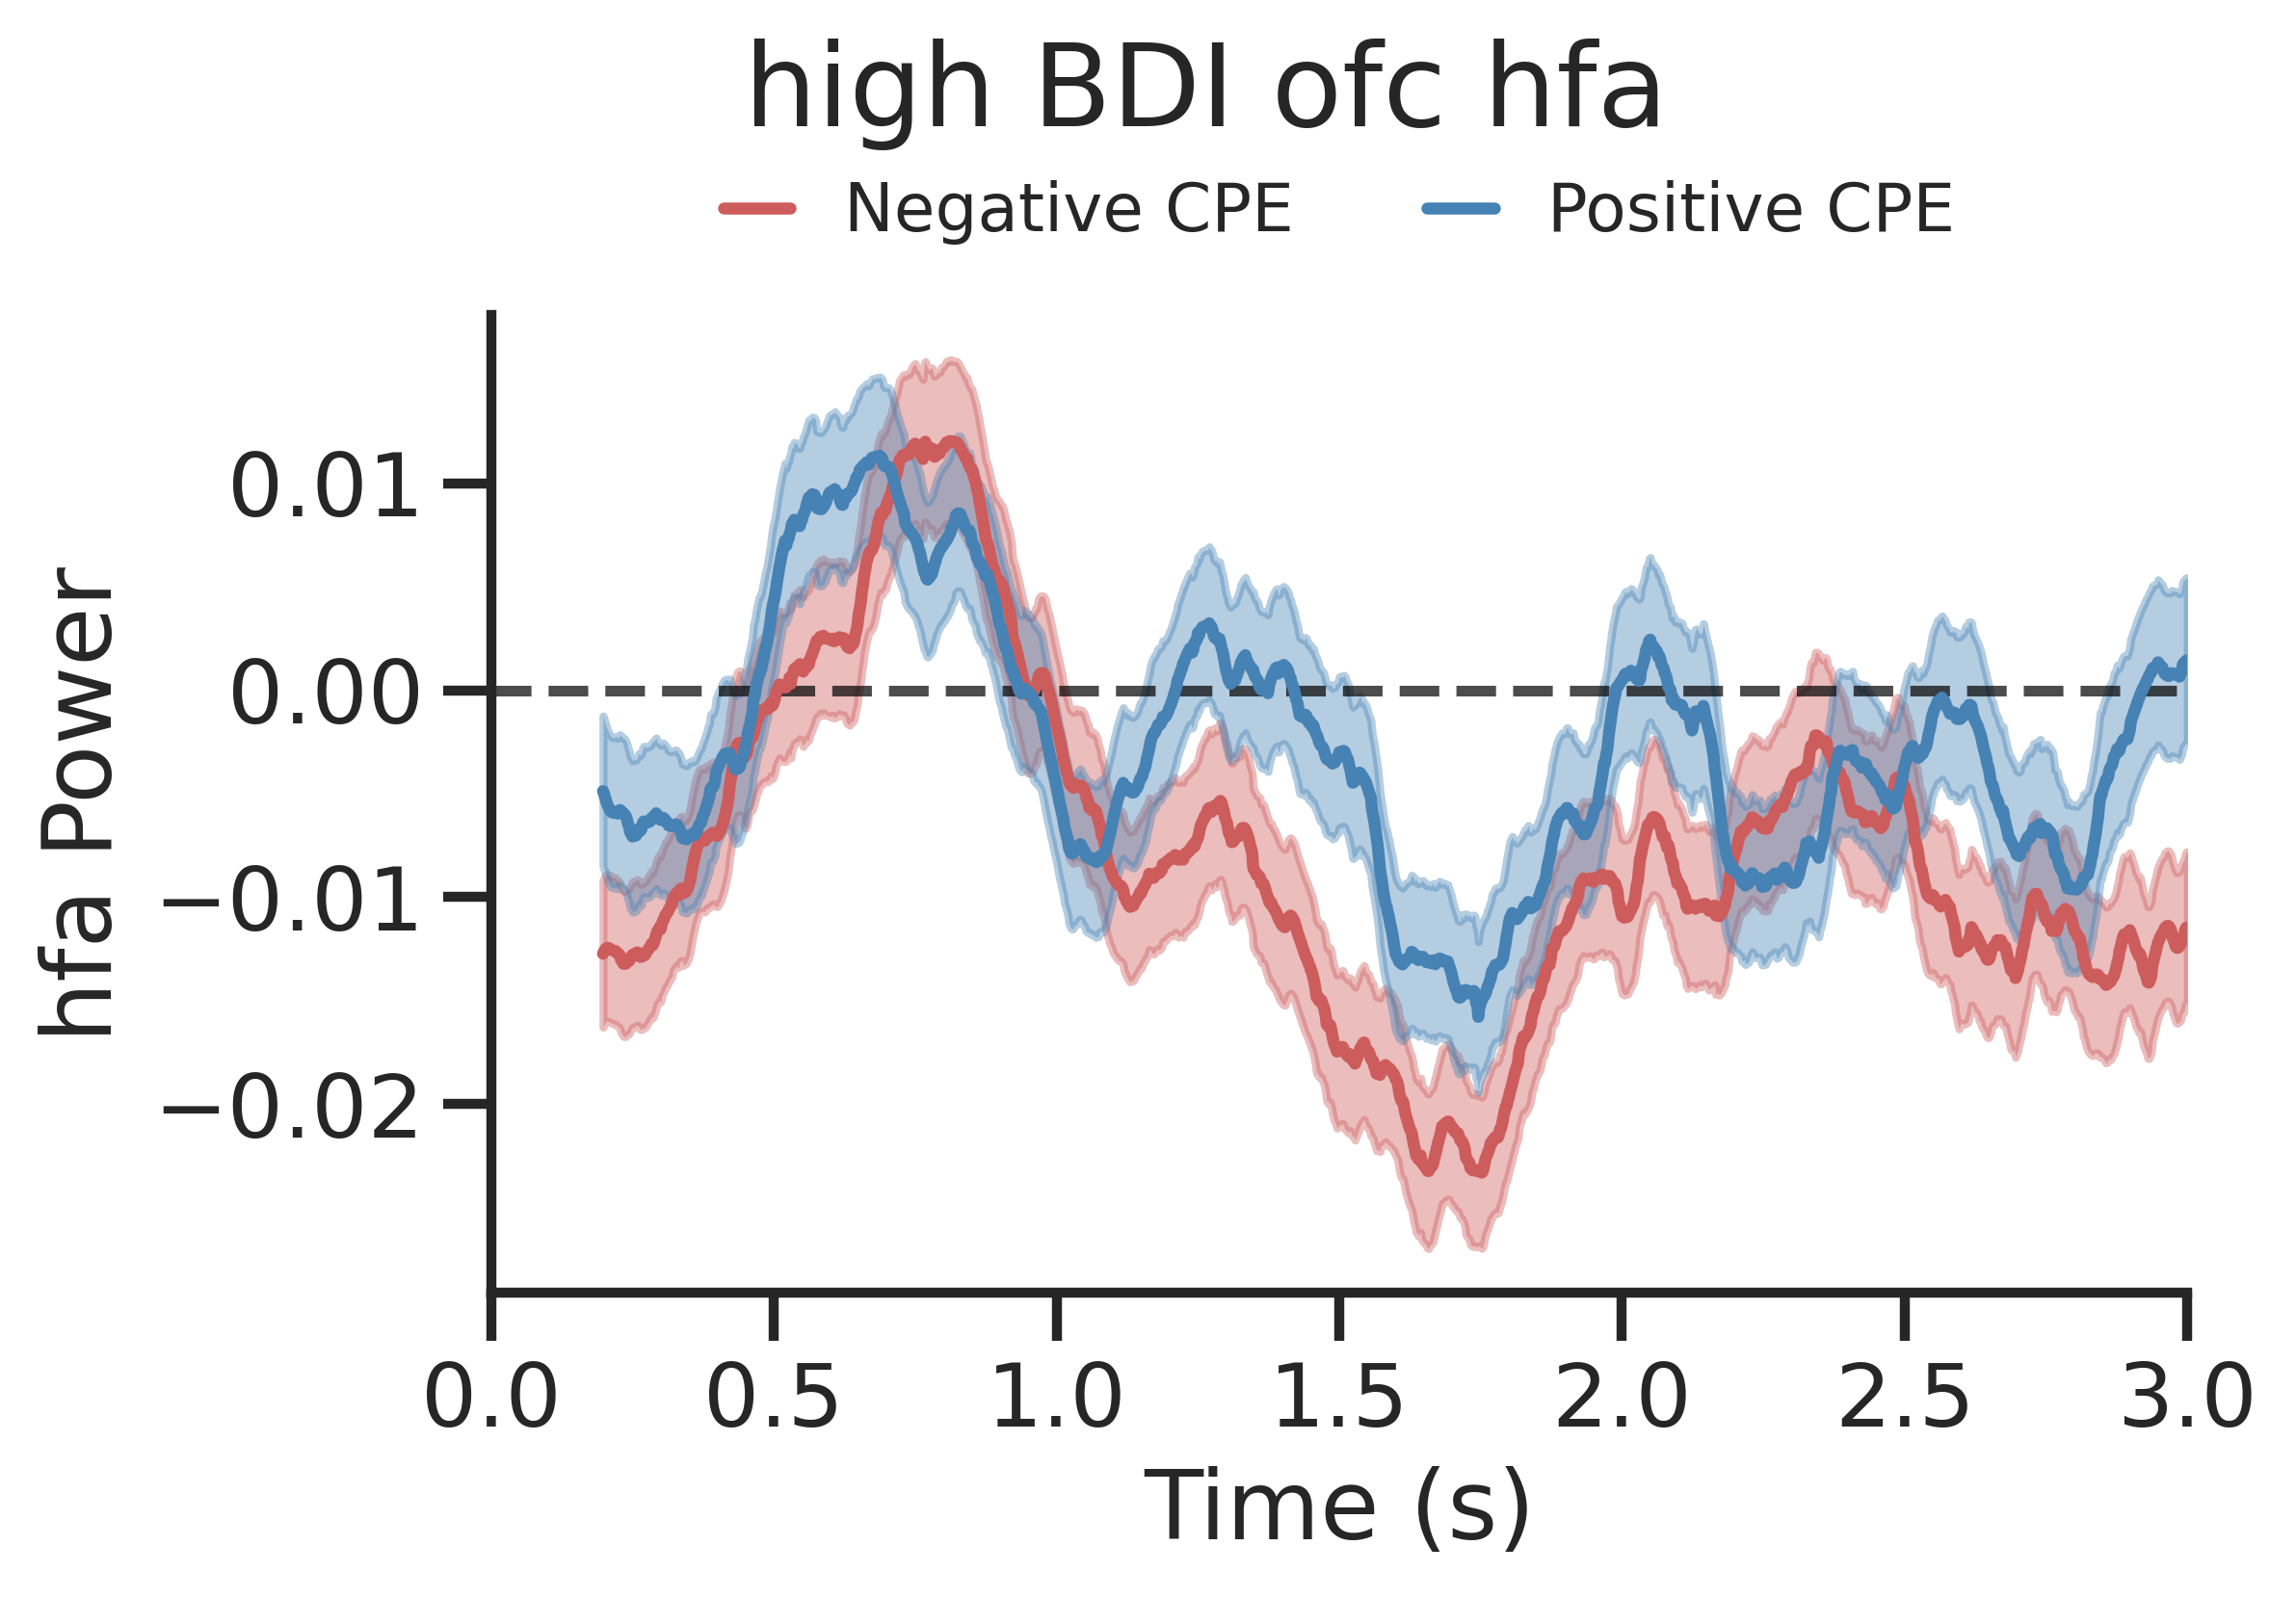

In [22]:
# roi_ylim = [-0.075,0.175]
# roi_ylim = [-0.05,0.05]

for bdi in roi_band_pow.bdi_thresh.unique().tolist():
    
#     if bdi_ix == 0:
#         bdi = 'low'
#     else:
#         bdi = 'high'

    bdi_data = roi_band_pow[roi_band_pow.bdi_thresh == bdi].reset_index(drop=True)
    
    bdi_data['power'] = bdi_data.groupby(['unique_reref_ch','epoch']).band_pow.rolling(
        window=100).mean().reset_index(drop=True)
    
    
    power_avg = bdi_data.groupby(['time','cpe_split']).agg(power_mean=('power', 'mean'), 
                                    power_sem=('power', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()
    
    fig_name = f'{fig_dir}{bdi}BDI_{plot_roi}_{plot_band}.pdf'
    
    fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=400)
    
    plt.axhline(0, color='black', linestyle='--',linewidth=2,alpha=0.7)
#     plt.ylim(roi_ylim)
    plt.xlim([0.0,3.0])
    
    # Plot the time resolved power with SEM shading
    for i, cpe_split in enumerate(bdi_data['cpe_split'].unique()):
        
        subset = power_avg[power_avg['cpe_split'] == cpe_split]
        
        plt.plot(subset['time'], subset['power_mean'], label=labels[i],color=sem_colors[i])
        
        ax.legend(frameon=False,loc='upper center', bbox_to_anchor=(0.5, 0.5,0,0.7),ncol=2,
                framealpha=0,fontsize='x-small',shadow=None,markerscale=4,handlelength=1)

        plt.fill_between(subset['time'], subset['power_mean'] - subset['power_sem'], 
             subset['power_mean'] + subset['power_sem'], color=sem_colors[i], alpha=0.4)
        del subset


    fig.tight_layout()
    fig.suptitle(f'{bdi} BDI {plot_roi} {plot_band}')
#     ax.set_title(f'{bdi}BDI {plot_roi} {plot_band}',fontsize=20)
    plt.xlabel(r'Time (s)')
#     plt.ylabel(fr'${plot_band}_{{zpow}}$')
    plt.ylabel(f'{plot_band} Power')
#     plt.xlim(0,3.0)
    
    sns.despine()

    plt.savefig(fig_name,dpi=400,format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    
    del bdi_data,power_avg



In [ ]:


# for bdi_thresh in roi_band_pow.bdi_split.unique().tolist():
    
#     if bdi_thresh == 0:
#         bdi = 'low'
#     else:
#         bdi = 'high'

#     bdi_data = roi_band_pow[roi_band_pow.bdi_split == bdi_thresh].reset_index(drop=True)
    
# #     bdi_data['power'] = bdi_data.groupby(['subj_id','cpe_split']
# #                                         ).band_pow.rolling(window=100).mean().reset_index(drop=True)
    
#     bdi_data['power'] = bdi_data.groupby(['cpe_split']
#                                         ).band_pow.rolling(window=500).mean().reset_index(drop=True)
    
    
#     power_avg = bdi_data.groupby(['time','cpe_split']).agg(power_mean=('power', 'mean'), 
#                                     power_sem=('power', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()
# #     power_avg
#     roi_ylim = [np.round(np.min(power_avg.power_mean)-0.01,3),
#                 np.round(np.max(power_avg.power_mean)+0.01,3)]
    
#     fig_name = f'{fig_dir}{bdi}BDI_{plot_roi}_{plot_band}.pdf'
    
#     fig,ax    = plt.subplots(1,1,figsize=(6,4),dpi=400)
    
#     plt.axhline(0, color='black', linestyle='--',linewidth=2,alpha=0.7)
#     plt.ylim(roi_ylim)
    
#     # Plot the time resolved power with SEM shading
#     for i, cpe_split in enumerate(bdi_data['cpe_split'].unique()):
        
#         subset = power_avg[power_avg['cpe_split'] == cpe_split]
        
# #         subset['power'] = subset.band_pow.rolling(window=50).mean()
# #         power_avg = subset.groupby(['time']).agg(power_mean=('band_pow', 'mean'), 
# #                                                 power_sem=('band_pow', lambda x: np.std(x)/np.sqrt(len(x)))
# #                                                 ).reset_index()
# #         subset = bdi_data[bdi_data['cpe_split'] == cpe_split].groupby('time').agg('mean',numeric_only=True).reset_index()
        
# # #         subset['power'] = subset.band_pow.rolling(window=50).mean()
        
# #         power_sem = np.std(subset.band_pow)/np.sqrt(len(subset))
        
#         plt.plot(subset['time'], subset['power_mean'], label=labels[i],color=sem_colors[i])
        
#         ax.legend(frameon=False,loc='upper center', bbox_to_anchor=(0.5, 0.5,0,0.7),ncol=2,
#                 framealpha=0,fontsize='x-small',shadow=None,markerscale=4,handlelength=1)

#         plt.fill_between(subset['time'], subset['power_mean'] - subset['power_sem'], 
#              subset['power_mean'] + subset['power_sem'], color=sem_colors[i], alpha=0.4)
#         del subset


#     fig.tight_layout()
#     fig.suptitle(f'{bdi}BDI {plot_roi} {plot_band}')
# #     ax.set_title(f'{bdi}BDI {plot_roi} {plot_band}',fontsize=20)
#     plt.xlabel(r'Time (s)')
# #     plt.ylabel(fr'${plot_band}_{{zpow}}$')
#     plt.ylabel('Beta Power')
# #     plt.ylim(roi_ylim)
    
#     sns.despine()

#     plt.savefig(fig_name,dpi=400,format='pdf', metadata=None,
#     bbox_inches='tight', pad_inches=0.1,
#     facecolor='auto', edgecolor='auto',
#     backend=None)
    
#     del bdi_data,power_avg



In [ ]:


# for bdi_thresh in roi_band_pow.bdi_split.unique().tolist():
    
#     if bdi_thresh == 0:
#         bdi = 'low'
#     else:
#         bdi = 'high'

#     bdi_data = roi_band_pow[roi_band_pow.bdi_split == bdi_thresh].reset_index(drop=True)
    
# #     bdi_data['power'] = bdi_data.groupby(['subj_id','cpe_split']
# #                                         ).band_pow.rolling(window=100).mean().reset_index(drop=True)
    
#     bdi_data['power'] = bdi_data.groupby(['cpe_split']
#                                         ).band_pow.rolling(window=250).mean().reset_index(drop=True)
    
    
#     power_avg = bdi_data.groupby(['time','cpe_split']).agg(power_mean=('power', 'mean'), 
#                                     power_sem=('power', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()
# #     power_avg
#     roi_ylim = [np.round(np.min(power_avg.power_mean)-0.01,3),
#                 np.round(np.max(power_avg.power_mean)+0.01,3)]
    
#     fig_name = f'{fig_dir}{bdi}BDI_{plot_roi}_{plot_band}.pdf'
    
#     fig,ax    = plt.subplots(1,1,figsize=(6,4),dpi=400)
    
#     plt.axhline(0, color='black', linestyle='--',linewidth=2,alpha=0.7)
    
#     # Plot the time resolved power with SEM shading
#     for i, cpe_split in enumerate(bdi_data['cpe_split'].unique()):
        
#         subset = power_avg[power_avg['cpe_split'] == cpe_split]
        
# #         subset['power'] = subset.band_pow.rolling(window=50).mean()
# #         power_avg = subset.groupby(['time']).agg(power_mean=('band_pow', 'mean'), 
# #                                                 power_sem=('band_pow', lambda x: np.std(x)/np.sqrt(len(x)))
# #                                                 ).reset_index()
# #         subset = bdi_data[bdi_data['cpe_split'] == cpe_split].groupby('time').agg('mean',numeric_only=True).reset_index()
        
# # #         subset['power'] = subset.band_pow.rolling(window=50).mean()
        
# #         power_sem = np.std(subset.band_pow)/np.sqrt(len(subset))
        
#         plt.plot(subset['time'], subset['power_mean'], label=labels[i],color=sem_colors[i])
        
#         ax.legend(frameon=False,loc='upper center', bbox_to_anchor=(0.5, 0.5,0,0.7),ncol=2,
#                 framealpha=0,fontsize='x-small',shadow=None,markerscale=4,handlelength=1)

#         plt.fill_between(subset['time'], subset['power_mean'] - subset['power_sem'], 
#              subset['power_mean'] + subset['power_sem'], color=sem_colors[i], alpha=0.4)
#         del subset


#     fig.tight_layout()
#     fig.suptitle(f'{bdi}BDI {plot_roi} {plot_band}')
# #     ax.set_title(f'{bdi}BDI {plot_roi} {plot_band}',fontsize=20)
#     plt.xlabel(r'Time (ms)')
#     plt.ylabel(fr'${plot_band}_{{zpow}}$')
#     plt.ylim(roi_ylim)
    
#     sns.despine()

#     plt.savefig(fig_name,dpi=400,format='pdf', metadata=None,
#     bbox_inches='tight', pad_inches=0.1,
#     facecolor='auto', edgecolor='auto',
#     backend=None)
    
#     del bdi_data,power_avg



In [ ]:
# plot_data_dict = {}


# for bdi_thresh in roi_plot_df.bdi_split.unique():
#     bdi_data = roi_plot_df[roi_plot_df.bdi_split == bdi_thresh].reset_index(drop=True)
    
#     bdi_data['new_pow'] = np.nan
    
#     if bdi_thresh == 0:
#         bdi = 'low'
#     else:
#         bdi = 'high'

#     for elec in bdi_data.unique_reref_ch.unique().tolist():
#         elec_df = bdi_data[bdi_data.unique_reref_ch == elec]
#         elec_df['power'] = elec_df.band_pow.rolling(window=500).mean()
#         bdi_data['new_pow'][bdi_data.unique_reref_ch == elec] = elec_df['power']
#         del elec_df

        
#     power_avg = bdi_data.groupby(['time','cpe_split']).agg(power_mean=('new_pow', 'mean'), 
#                                                     power_sem=('new_pow', lambda x: np.std(x)/np.sqrt(len(x)))
#                                                     ).reset_index()
#     plot_data_dict[bdi_thresh] = power_avg
    
#     del power_avg, bdi_data

In [ ]:
#             # add a median split column for the expected value
#             power['ev_split'] = pd.qcut(power['ev_zscore'], 2, labels=False)
#             power['power'] = scipy.signal.savgol_filter(power['power'], 500, 3)

#             # calculate average power and SEM for each time point 
#             power_avg = power.groupby(['time','ev_split']).agg(power_mean=('power', 'mean'), power_sem=('power', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()
            
#             # plot the time resolved power
#             sns.set_context('talk')
#             sns.set_style('white')
#             sns.set_palette('colorblind')
#             plt.figure(figsize=(2, 1))

#             sem_colors = ['red', 'green']

#             # Plot the time resolved power with SEM shading
#             for i, ev_split in enumerate(power_avg['ev_split'].unique()):
#                 subset = power_avg[power_avg['ev_split'] == ev_split]
#                 plt.plot(subset['time'], subset['power_mean'], label=f'EV Split {ev_split}')
#                 plt.fill_between(subset['time'], subset['power_mean'] - subset['power_sem'], subset['power_mean'] + subset['power_sem'], color=sem_colors[i], alpha=0.3)


In [ ]:
    #     bdi_data = roi_band_pow[roi_band_pow.bdi_split == bdi_thresh].reset_index(drop=True).groupby(
#         ['time','cpe_split']).agg('mean',numeric_only=True).reset_index()


#     bdi_data['power'] = bdi_data.groupby('subj_id').band_pow.rolling(window=100).mean().reset_index()
    
#     scipy.signal.savgol_filter(elec_df['band_pow'], 500, 3)
#     bdi_data['power'] = np.nan
#     for elec in bdi_data.unique_reref_ch.unique().tolist():
#         elec_df = bdi_data[bdi_data.unique_reref_ch == elec]
# #         elec_df['power'] = elec_df.band_pow.rolling(window=100).mean()
#         elec_df['power'] = scipy.signal.savgol_filter(elec_df['band_pow'], 500, 3)
#         bdi_data['power'][bdi_data.unique_reref_ch == elec] = elec_df['power']


#     bdi_data['power'] = bdi_data.groupby('time').band_pow.rolling(window=500).mean().reset_index()
#     bdi_data['power'] = scipy.signal.savgol_filter(bdi_data['band_pow'], 500, 3)

    




#     bdi_data['power'] = bdi_data.band_pow.rolling(window=50).mean()
    
#     power_avg = bdi_data.agg(power_sem=('power', lambda x: np.std(x)/np.sqrt(len(x))))
#     power_avg = bdi_data.agg(power_sem=('power', lambda x: np.std(x)/np.sqrt(len(x))))

In [ ]:
# del roi_band_pow

In [ ]:
# ### get min/max values for y axis 
# max_pow = np.max(np.array([np.max(plot_data_dict[0]['power_mean']),np.max(plot_data_dict[1]['power_mean'])]))+0.015
# # max_pow
# min_pow = np.min(np.array([np.min(plot_data_dict[0]['power_mean']),np.min(plot_data_dict[1]['power_mean'])]))+-0.015
# # min_pow
# if max_pow < 0: 
#     max_pow = 0.01
# if min_pow > 0:
#     min_pow = -0.01
# roi_ylim = np.array([np.round(min_pow,2),np.round(max_pow,2)])
# roi_ylim


## Plot Time Series

In [ ]:
# # Let's load the power epochs for specific conditions: 

# analysis_evs = ['feedback_start']

# # band definitions for y-axis
# # yticks = [4, 8, 13, 30, 60, 120]

# # task condition to contrast 

# # cond_name = 'rpe'

# # conditions = ['(rpe>0)',
# #              '(rpe<0)']

# cond_name = 'SME_posRPE'

# conditions = ['(rpe<0) & (hits==1)',
#              '(rpe<0) & (hits==0)']



# tfr_group_data = {f'{a}': {f'{b}': [] for b in conditions} for a in rois}

# power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}

# for subj_id in subj_ids: 
#     for event in analysis_evs:
#         filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
#         power_epochs[subj_id][event] = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]
                
#         # replace IED metadata with behavioral metadata
#         if 'SME' in cond_name:
#             epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1

#             power_epochs[subj_id][event] = power_epochs[subj_id][event][epochs_to_analyze.astype(int)]

#             power_epochs[subj_id][event].metadata = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True)
#         else:
#             power_epochs[subj_id][event].metadata = learn_df[(learn_df.participant==subj_id)]
            
#         # Get electrode df 
#         elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')
        
        
#         progress_bar = tqdm(elec_df.label, ascii=True, desc='Aggregating TFRs')

#         for elec_ix, chan in enumerate(progress_bar):
#             region = elec_df.salman_region.iloc[elec_ix]
#             if region in rois:
#                 for ix, cond in enumerate(conditions):
#                     # Set the times for 
#                     times = power_epochs[subj_id][event].times
#                     if 'SME' in cond_name:
#                         plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
#                     else:
#                         plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
#                     tfr_group_data[region][cond].append(plot_data)                    
                    

In [ ]:
# freqs = np.logspace(*np.log10([2, 200]), num=30)

# for region in rois: 
#     # if region == 'TC':
#     #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
#     fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
#     for ix, cond in enumerate(conditions): 
#         # Set the times for 
#         n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
#         times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

#         plot_data = np.nanmean(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
                
#         im = ax[ix].imshow(dat_[ch_, :, :],
#                           aspect='auto', origin='lower', cmap='Spectral_r', interpolation = 'bicubic')            
#         ax[ix].set(xlabel='Time (s)', ylabel='Frequency', title=f'{cond}_{region}_nelec={n_elecs}')

#         # Set custom y-axis ticks and labels
#         freq_res = 5
#         time_res = 250 
#         ax[ix].set(yticks=np.arange(0, len(freqs))[::freq_res], 
#                yticklabels=freqs[::freq_res].astype(int), 
#                xticks = np.arange(len(times))[::time_res],
#                xticklabels= zpow.times[::time_res])

#         fig.colorbar(im, ax=ax[ix])
#         plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_TFR_{cond_name}_{region}.pdf', dpi=300)

        
        

In [ ]:
# for region in rois: 
#     # if region == 'TC':
#     #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
#     fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300, sharey=True, sharex=True)
#     for ix, cond in enumerate(conditions): 
#         # Set the times for 
#         n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
#         times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

# #         if cond_name == 'SME':
# #             plot_data = np.nanmedian(np.nanmedian(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0), axis=0)
# #         else:
#         plot_data = np.nanmean(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
#         ax.plot(times, np.nanmean(plot_data[freqs<9, :], axis=0))
      
#         ax.set(xlabel='Time (s)', ylabel='Power (z)', title=f'{cond}_{region}_nelec={n_elecs}')
#         # fig.colorbar(im, ax=ax[ix])
#         plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_theta_{cond_name}_{region}.pdf', dpi=300)
